In [5]:
n_states

np.int64(16)

--- Iniciando Entrenamiento Q-Learning ---
Entorno: FrozenLake-v1 (4x4, Determinista)
Estados: 16, Acciones: 4
Parámetros: α=0.1, γ=0.95, ε-decay=0.0005
Episodios: 20000
----------------------------------------
Episodio:  1000/20000 | Tasa Éxito (últimos 1000):  10.80% | Pasos Prom (últimos 1000):    8.0 | Epsilon: 0.611
Episodio:  2000/20000 | Tasa Éxito (últimos 1000):  40.90% | Pasos Prom (últimos 1000):    7.6 | Epsilon: 0.374
Episodio:  3000/20000 | Tasa Éxito (últimos 1000):  65.60% | Pasos Prom (últimos 1000):    6.9 | Epsilon: 0.231
Episodio:  4000/20000 | Tasa Éxito (últimos 1000):  79.90% | Pasos Prom (últimos 1000):    6.5 | Epsilon: 0.144
Episodio:  5000/20000 | Tasa Éxito (últimos 1000):  88.70% | Pasos Prom (últimos 1000):    6.4 | Epsilon: 0.091
Episodio:  6000/20000 | Tasa Éxito (últimos 1000):  92.60% | Pasos Prom (últimos 1000):    6.2 | Epsilon: 0.059
Episodio:  7000/20000 | Tasa Éxito (últimos 1000):  96.00% | Pasos Prom (últimos 1000):    6.1 | Epsilon: 0.040
Episo

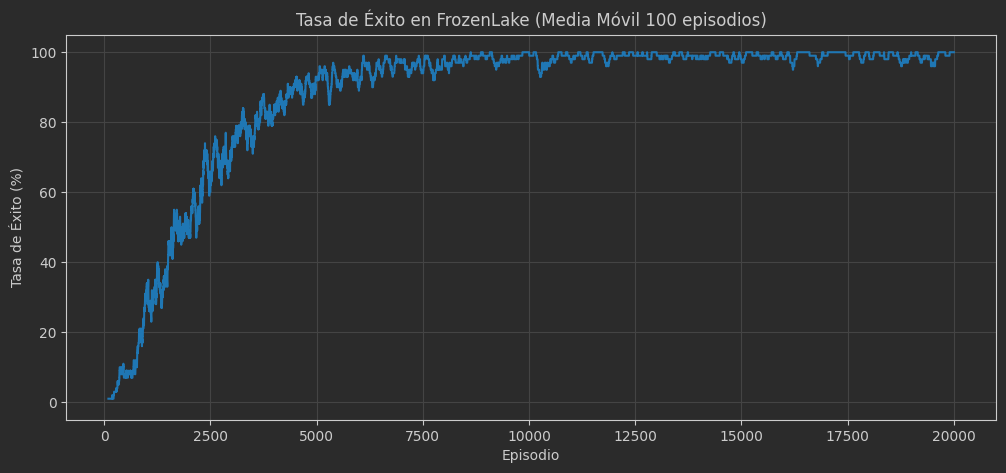


Política Aprendida (Flechas):
-----------------
| ↓ | → | ↓ | ← |
-----------------
| ↓ | H | ↓ | H |
-----------------
| → | → | ↓ | H |
-----------------
| H | → | → | G |
-----------------

--- Fin del Análisis ---


In [4]:
# -*- coding: utf-8 -*-
"""q_learning_frozenlake_01.ipynb

Automatically generated by Colab.


"""

# =====================================================================
# Q-Learning
#
# =====================================================================
# Materia: Aprendizaje por Refuerzo I
# Carrera: Maestria en Inteligencia Artificial - Universidad de Buenos Aires
# Año: 2025
# Docente: Miguel Augusto Azar
# =====================================================================

'''

Frozenlake
===================================



'''
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import time # Para medir tiempo y para pausas si se renderiza

plt.rcParams.update({
    'figure.facecolor': '#2b2b2b',     # fondo exterior
    'axes.facecolor':   '#2b2b2b',     # fondo del área del gráfico
    'axes.edgecolor':   '#cccccc',     # borde de los ejes
    'axes.labelcolor':  '#cccccc',     # etiquetas de los ejes
    'xtick.color':      '#cccccc',     # color de los números en el eje X
    'ytick.color':      '#cccccc',     # color de los números en el eje Y
    'text.color':       '#cccccc',     # color del título y textos
    'grid.color':       '#444444',     # color de la grilla
})


# --- Parámetros ---
# Entorno
env_name = "FrozenLake-v1"
# 'is_slippery=False' para determinista, 'True' para estocástico
slippery = False
map_name = "4x4" # Puedes probar "8x8" si quieres un reto mayor
max_steps_per_episode = 100 # Límite de pasos por episodio

# Q-Learning
learning_rate = 0.1        # Alpha: Tasa de aprendizaje
discount_factor = 0.95     # Gamma: Factor de descuento (valor de recompensas futuras)
num_episodes = 20000       # Número de episodios para entrenar

# Exploración (Epsilon-Greedy)
epsilon = 1.0              # Tasa de exploración inicial (100% aleatorio)
max_epsilon = 1.0          # Máximo valor de epsilon
min_epsilon = 0.01         # Mínimo valor de epsilon
epsilon_decay_rate = 0.0005 # Tasa de decaimiento de epsilon por episodio

# Para reporte/gráficas
report_interval = num_episodes // 20 # Cada cuántos episodios mostrar progreso
moving_avg_window = 100    # Ventana para la media móvil en la gráfica

# --- Inicialización ---
env = gym.make(
    env_name,
    desc=None, # Usar mapa por defecto basado en map_name
    map_name=map_name,
    is_slippery=slippery,
    max_episode_steps=max_steps_per_episode,
    # render_mode="human" # Descomentar para visualizar entrenamiento (MUY LENTO)
)

n_states = env.observation_space.n
n_actions = env.action_space.n

# Inicializar la tabla Q con ceros
q_table = np.zeros((n_states, n_actions))

# Lista para guardar recompensas y pasos por episodio
rewards_all_episodes = []
steps_all_episodes = []

print(f"--- Iniciando Entrenamiento Q-Learning ---")
print(f"Entorno: {env_name} ({map_name}, {'Estocástico' if slippery else 'Determinista'})")
print(f"Estados: {n_states}, Acciones: {n_actions}")
print(f"Parámetros: α={learning_rate}, γ={discount_factor}, ε-decay={epsilon_decay_rate}")
print(f"Episodios: {num_episodes}")
print("-" * 40)

start_time = time.time()

# --- Bucle de Entrenamiento ---
for episode in range(num_episodes):
    # Reiniciar entorno
    state, info = env.reset()
    terminated = False
    truncated = False # Indica si se superó max_steps_per_episode

    total_reward_episode = 0
    steps_episode = 0

    while not terminated and not truncated:
        # 1. Elegir Acción (Epsilon-Greedy)
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explorar
        else:
            action = np.argmax(q_table[state, :]) # Explotar

        # 2. Ejecutar Acción
        new_state, reward, terminated, truncated, info = env.step(action)

        # 3. Actualizar Q-Table (Fórmula de Bellman)
        # El valor futuro (max Q del siguiente estado) es 0 si el episodio terminó
        q_update_target = reward + discount_factor * np.max(q_table[new_state, :]) * (1 - terminated)
        q_table[state, action] = q_table[state, action] + learning_rate * (q_update_target - q_table[state, action])

        # Actualizar estado y contadores
        state = new_state
        total_reward_episode += reward
        steps_episode += 1

        # Renderizar si está activado
        # if env.render_mode == "human":
        #     env.render()
        #     time.sleep(0.01) # Pausa para poder ver

    # Fin del episodio
    rewards_all_episodes.append(total_reward_episode)
    steps_all_episodes.append(steps_episode)

    # 4. Decaimiento de Epsilon (exponencial)
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay_rate * episode)

    # Reportar progreso
    if (episode + 1) % report_interval == 0:
        # Calcular tasa de éxito reciente
        recent_episodes = rewards_all_episodes[-report_interval:]
        success_rate = np.mean([1 if r > 0 else 0 for r in recent_episodes]) * 100
        avg_steps = np.mean(steps_all_episodes[-report_interval:])
        print(f"Episodio: {episode+1:>5}/{num_episodes} | "
              f"Tasa Éxito (últimos {report_interval}): {success_rate:>6.2f}% | "
              f"Pasos Prom (últimos {report_interval}): {avg_steps:>6.1f} | "
              f"Epsilon: {epsilon:.3f}")

env.close()
end_time = time.time()
print("-" * 40)
print(f"Entrenamiento finalizado en {end_time - start_time:.2f} segundos.")
print("-" * 40)


# --- Resultados ---

# 1. Mostrar Tabla Q final (opcional, puede ser grande)
print("\nTabla Q Final (primeros 5 estados):")
np.set_printoptions(precision=3, suppress=True)
print(q_table[:5, :]) # Mostrar solo las primeras filas

# 2. Gráfica de Convergencia (Tasa de Éxito con Media Móvil)
if len(rewards_all_episodes) >= moving_avg_window:
    # Calcular tasa de éxito (1 si recompensa > 0)
    success_rate_all = [1 if r > 0 else 0 for r in rewards_all_episodes]
    # Calcular media móvil
    moving_avg_success = np.convolve(success_rate_all, np.ones(moving_avg_window)/moving_avg_window, mode='valid')

    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(moving_avg_window - 1, num_episodes), moving_avg_success * 100)
    plt.title(f"Tasa de Éxito en FrozenLake (Media Móvil {moving_avg_window} episodios)")
    plt.xlabel("Episodio")
    plt.ylabel("Tasa de Éxito (%)")
    plt.grid(True)
    plt.ylim(-5, 105)
    plt.show()
else:
    print("No hay suficientes episodios para calcular la media móvil.")
    plt.figure(figsize=(12, 5))
    plt.plot(rewards_all_episodes)
    plt.title("Recompensa por Episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa Total")
    plt.grid(True)
    plt.show()


# 3. Mostrar Política Aprendida (Flechas en el Mapa)
print("\nPolítica Aprendida (Flechas):")
try:
    desc = env.unwrapped.desc.astype(str) # Obtener el mapa
    rows, cols = desc.shape
except AttributeError:
    print("Advertencia: No se pudo obtener 'desc' del entorno. Asumiendo 4x4.")
    rows, cols = (4, 4) if map_name == "4x4" else (8, 8)
    desc = None # No podemos mostrar H, G si no tenemos desc

# Mapeo de acciones de FrozenLake a flechas (0: Izq, 1: Aba, 2: Der, 3: Arr)
action_arrows = {0: '←', 1: '↓', 2: '→', 3: '↑'}

print("-" * (cols * 4 + 1)) # Borde superior
for r in range(rows):
    print("|", end="")
    for c in range(cols):
        state = r * cols + c
        char = "?"
        if desc is not None:
            char = desc[r, c]

        if char in "HG": # Estados terminales
            policy_char = f" {char} "
        elif np.all(q_table[state] == 0): # Estado no explorado o sin preferencia
            policy_char = " . "
        else:
            best_action = np.argmax(q_table[state, :])
            policy_char = f" {action_arrows.get(best_action, '?')} " # Obtener flecha

        print(policy_char + "|", end="")
    print() # Nueva línea para la siguiente fila
    print("-" * (cols * 4 + 1)) # Separador de filas

print("\n--- Fin del Análisis ---")